In [121]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import pandas as pd
import sklearn
from utils import *
from models.MNL import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
%matplotlib inline
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# usps dataset from kaggle
import h5py
path = './data/usps.h5'
with h5py.File(path, 'r') as hf:
    train_data = hf.get('train')
    X_tr = np.array(train_data.get('data')[:])
    usps_y_tr = train_data.get('target')[:]
    test_data = hf.get('test')
    X_te = np.array(test_data.get('data')[:])
    usps_y_te = test_data.get('target')[:]


usps_X_tr = [[] for i in range(len(X_tr))]
usps_X_te = [[] for i in range(len(X_te))]

for i in range(len(X_tr)):
    temp = np.array(X_tr[i].reshape(16,16))
    temp = cv2.resize(temp, (28, 28), interpolation=cv2.INTER_CUBIC)
    usps_X_tr[i] = temp.flatten()

              
for i in range(len(usps_X_te)):
    temp = np.array(X_te[i].reshape(16,16))
    temp = cv2.resize(temp, (28, 28), interpolation=cv2.INTER_CUBIC)
    usps_X_te[i] = temp.flatten()
    
usps_X_tr = np.array(usps_X_tr)
usps_X_te = np.array(usps_X_te)

print(np.array(usps_X_tr).shape, np.array(usps_X_te).shape)

(7291, 784) (2007, 784)


[9 6 3 6 6 0 0 0 6 9]


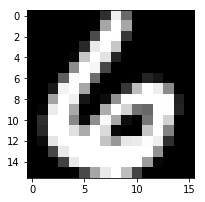

In [123]:
print(usps_y_te[:10])
pic_n = 1
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(X_tr[0].reshape([16, 16]), 'gray')

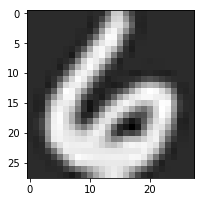

In [124]:
size=28
img = np.array(X_tr[0].reshape(16,16))
res = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)
fig, ax = plt.subplots(pic_n, 1, sharex = True, sharey = True, figsize=(3, 5))
for i in range(pic_n):
    ax.imshow(res, 'gray')

In [161]:
data = MNIST(one_hot=False, shuffle=False)

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# Hyper Parameters 
input_size = 784
num_classes = 10
batch_size = 1024
epochs = 20
learning_rate = 0.01
train_size = 1000
test_size = 1000

device = torch.device('cuda')
print(data.y_train.shape)
model = MNL(input_size, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

mnist_x_train = torch.from_numpy(data.x_test[:test_size]).contiguous().view(-1, data.x_train.shape[1], 
                                          data.x_train.shape[2], data.x_train.shape[3])
mnist_y_train = torch.from_numpy(data.y_test[:test_size]).view(-1,).long()
print("train_size:", mnist_x_test.shape)

mnist_x_test = torch.from_numpy(data.x_test).contiguous().view(-1, data.x_train.shape[1], 
                                          data.x_train.shape[2], data.x_train.shape[3])
mnist_y_test = torch.from_numpy(data.y_test).view(-1,).long()
print("test_size:", mnist_y_test.shape)

usps_x_train = torch.from_numpy(usps_X_tr[:test_size]).contiguous()
usps_y_train = torch.from_numpy(usps_y_tr[:test_size]).view(-1,).long()
usps_x_test = torch.from_numpy(usps_X_te[:test_size]).contiguous()
usps_y_test = torch.from_numpy(usps_y_te[:test_size]).view(-1,).long()

print(usps_x_train.shape)

train(model, device, usps_x_train, usps_y_train, batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(model, device, usps_x_train, usps_y_train[:train_size], batch_size, criterion)
print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

accuracy, avg_loss = evaluate(model, device, mnist_x_test, mnist_y_test, batch_size, criterion)
print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')

(60000,)
train_size: torch.Size([10000, 28, 28, 1])
test_size: torch.Size([10000])
torch.Size([1000, 784])



[Train] Accuracy: 48.70%, loss:  0.0017
[Test] Accuracy: 23.35%, loss:  0.0022


In [162]:
deep_f_train = []
deep_f_test = []
targets = []
for X, y in batch(usps_x_train, usps_y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = model(X)
    deep_f_train.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

for X, y in batch(mnist_x_train, mnist_y_train, batch_size):
    X = X.to(device).float()
    fc3, y_pre = model(X)
    deep_f_test.append(fc3.view(fc3.size(0), -1).cpu().detach().numpy())

deep_f_train = np.concatenate(deep_f_train) # deep features are not normalized
deep_f_test = np.concatenate(deep_f_test) # deep features are not normalized
print(deep_f_train.shape, deep_f_test.shape) 

(1000, 784) (1000, 784)


In [163]:
import math
kmin = 1
kmax = 10
kinterval = 1
fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features
loo_fc1_knn_values = [[] for _ in range(math.ceil((kmax-kmin)/kinterval))] # deep features

for i, k in enumerate(range(kmin, kmax, kinterval)):
    loo_fc1_knn_values[i], score, *_ = loo_knn_shapley(k, deep_f_train, deep_f_test, usps_y_train, mnist_y_test)
    print("neighbour number:", k, score)
    fc1_knn_values[i],*_ = old_knn_shapley(k, deep_f_train, deep_f_test, usps_y_train, mnist_y_test)

neighbour number: 1 0.345


neighbour number: 2 0.24


neighbour number: 3 0.308


neighbour number: 4 0.234


neighbour number: 5 0.264


neighbour number: 6 0.221


neighbour number: 7 0.248


neighbour number: 8 0.213


neighbour number: 9 0.237


In [164]:
# print(len(knn_values[1][0]))

(942,)
(945,)
(947,)
(951,)
(950,)
(950,)
(951,)
(953,)
(955,)


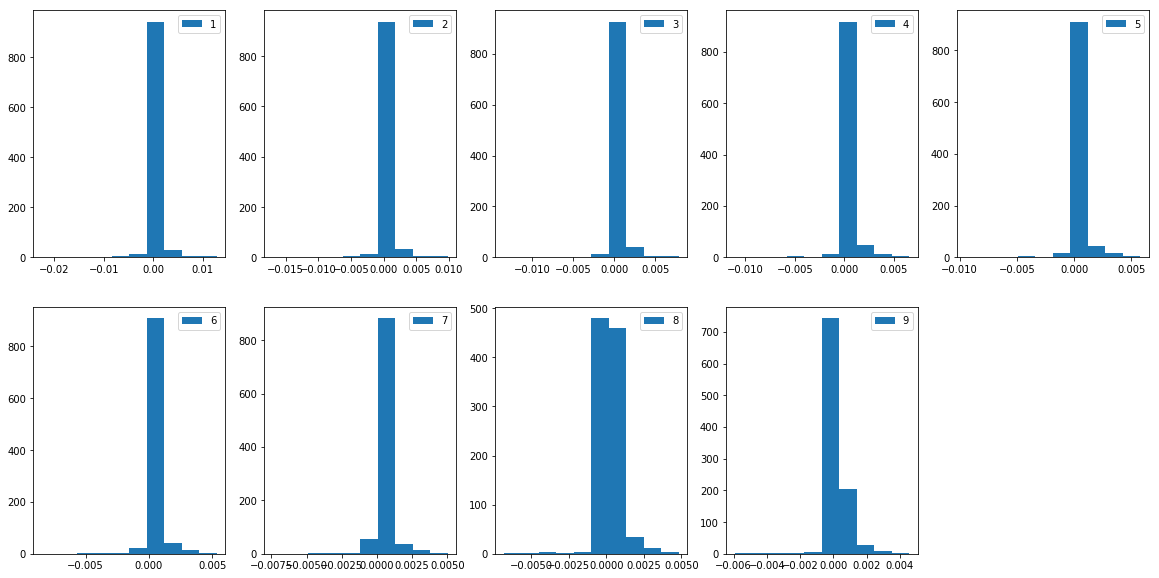

In [165]:
import pandas as pd
pd.options.display.max_columns = None
from IPython.display import display
class_weights = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
knn_values_idx = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
knn_values_advanced = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
loo_knn_values_idx = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
loo_knn_values_advanced = [[0.0 for i in range(10)] for i in range(kmin, kmax, kinterval)]
#removing negative data
for i in range(len(fc1_knn_values)):
#     print(i)
    knn_values_idx[i] = np.where(fc1_knn_values[i] > 0)[0]
    knn_values_advanced[i] = fc1_knn_values[i][np.where(fc1_knn_values[i] > 0)[0]]
    print(knn_values_idx[i].shape)
    loo_knn_values_idx[i] = np.where(loo_fc1_knn_values[i] > 0)[0]
    loo_knn_values_advanced[i] = loo_fc1_knn_values[i][np.where(loo_fc1_knn_values[i] > 0)[0]]

#     for j in range(train_size):
#         if(fc1_knn_values[i][j]>0):
#             class_weights[i][targets[j]] += fc1_knn_values[i][j]

# for i in range(len(class_weights)):
#     print(class_weights[i])
fig=plt.figure(figsize=(20, 10))
for i, k in enumerate(range(kmin, kmax, kinterval)):
#     print(i,k)
    fig.add_subplot( 2, 5, i+1)
    plt.hist(fc1_knn_values[i].astype('float'), label=k)
    plt.legend()
plt.show()

In [166]:
for i, k in enumerate(range(kmin, kmax, kinterval)):
    print("K=", k)
    device = torch.device('cuda')
    model = MNL(input_size, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    x_train_val, y_train_val = usps_x_train[knn_values_idx[i]], usps_y_train[knn_values_idx[i]]
    print(x_train_val.shape, y_train_val.shape)
    
    train(model, device, x_train_val, y_train_val, batch_size, optimizer, criterion, epochs)
    accuracy, avg_loss = evaluate(model, device, mnist_x_test, mnist_y_test, batch_size, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    
    model = MNL(input_size, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    x_train_val, y_train_val = usps_x_train[loo_knn_values_idx[i]], usps_y_train[loo_knn_values_idx[i]]
    print(x_train_val.shape, y_train_val.shape)
    
    train(model, device, x_train_val, y_train_val, batch_size, optimizer, criterion, epochs)
    accuracy, avg_loss = evaluate(model, device, mnist_x_test, mnist_y_test, batch_size, criterion)
    print(f'loo [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    
    

K= 1
torch.Size([942, 784]) torch.Size([942])



[Test] Accuracy: 21.34%, loss:  0.0022
torch.Size([59, 784]) torch.Size([59])



loo [Test] Accuracy: 28.72%, loss:  0.0022
K= 2
torch.Size([945, 784]) torch.Size([945])



[Test] Accuracy: 26.09%, loss:  0.0022
torch.Size([87, 784]) torch.Size([87])



loo [Test] Accuracy: 26.07%, loss:  0.0022
K= 3
torch.Size([947, 784]) torch.Size([947])



[Test] Accuracy: 26.50%, loss:  0.0022
torch.Size([116, 784]) torch.Size([116])



loo [Test] Accuracy: 26.77%, loss:  0.0022
K= 4
torch.Size([951, 784]) torch.Size([951])



[Test] Accuracy: 27.56%, loss:  0.0022
torch.Size([130, 784]) torch.Size([130])



loo [Test] Accuracy: 30.01%, loss:  0.0022
K= 5
torch.Size([950, 784]) torch.Size([950])



[Test] Accuracy: 24.59%, loss:  0.0022
torch.Size([129, 784]) torch.Size([129])



loo [Test] Accuracy: 31.22%, loss:  0.0022
K= 6
torch.Size([950, 784]) torch.Size([950])



[Test] Accuracy: 25.17%, loss:  0.0022
torch.Size([152, 784]) torch.Size([152])



loo [Test] Accuracy: 35.95%, loss:  0.0022
K= 7
torch.Size([951, 784]) torch.Size([951])



[Test] Accuracy: 26.42%, loss:  0.0022
torch.Size([141, 784]) torch.Size([141])



loo [Test] Accuracy: 25.70%, loss:  0.0022
K= 8
torch.Size([953, 784]) torch.Size([953])



[Test] Accuracy: 28.49%, loss:  0.0022
torch.Size([143, 784]) torch.Size([143])



loo [Test] Accuracy: 26.35%, loss:  0.0022
K= 9
torch.Size([955, 784]) torch.Size([955])



[Test] Accuracy: 30.25%, loss:  0.0022
torch.Size([157, 784]) torch.Size([157])



loo [Test] Accuracy: 24.56%, loss:  0.0022


In [167]:
# load data
import pickle
with open('./temp_domainUspsMnist/mem_tmc_0000.pkl', 'rb') as f:
    tmc = pickle.load(f)
    tmc_values = np.mean(tmc["mem_tmc"],0)

with open('./temp_domainUspsMnist/loo.pkl', 'rb') as f:
    loo = pickle.load(f)
    loo_values = loo["loo"]
print(loo_values.shape)
print(loo_values[:10])



(1000,)
[-0.001  0.     0.    -0.001  0.     0.     0.     0.     0.    -0.001]


In [168]:
loo_values_idx = np.where(loo_values > 0)[0]
tmc_values_idx = np.where(tmc_values > 0)[0]
print(loo_values_idx.shape, tmc_values_idx.shape)

(189,) (663,)


In [171]:
seed = 10
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True
device = torch.device('cuda')
model = MNL(input_size, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train(model, device, usps_x_train[tmc_values_idx], usps_y_train[tmc_values_idx], batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(model, device, mnist_x_test, mnist_y_test, batch_size, criterion)
print(f'TMC [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


TMC [Test] Accuracy: 29.55%, loss:  0.0022


In [170]:
device = torch.device('cuda')
model = MNL(input_size, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train(model, device, usps_x_train[loo_values_idx], usps_y_train[loo_values_idx], batch_size, optimizer, criterion, epochs)
accuracy, avg_loss = evaluate(model, device, mnist_x_test, mnist_y_test, batch_size, criterion)
print(f'LOO [Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


LOO [Test] Accuracy: 23.53%, loss:  0.0022
